# Home 4: Build a seq2seq model for machine translation.

### Name: Zubair Shaikh

### Task: Translate English to Italian

## 0. You will do the following:

1. Read and run my code.
2. Complete the code in Section 1.1 and Section 4.2.

    * Translation English to **German** is not acceptable!!! Try another language.
    
3. **Make improvements.** Directly modify the code in Section 3. Do at least one of the followings. By doing more, you will get up to 2 bonus scores to the total.

    * Bi-LSTM instead of LSTM
    
    * Multi-task learning (e.g., both English to French and English to Spanish)
    
    * Attention
    
4. Evaluate the translation using the BLEU score. 

    * Optional. Up to 1 bonus scores to the total.
    
5. Convert the notebook to .HTML file. 

    * The HTML file must contain the code and the output after execution.

6. Put the .HTML file in your Google Drive, Dropbox, or Github repo. 

7. Submit the link to the HTML file to Canvas.    


### Hint: 

To implement ```Bi-LSTM```, you will need the following code to build the encoder; the decoder won't be much different.

In [0]:
# from keras.layers import Bidirectional, Concatenate, LSTM

# encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True, 
#                                     dropout=0.5, name='encoder_lstm'))
# _, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

# state_h = Concatenate()([forward_h, backward_h])
# state_c = Concatenate()([forward_c, backward_c])

In [0]:
# !apt install graphviz
# !pip install pydot pydot-ng
# !echo "Double check with Python 3"
# !python -c "import pydot"

### Hint: 

To implement multi-task training, you can refer to ```Section 7.1.3 Multi-output models``` of the textbook, ```Deep Learning with Python```.

## 1. Data preparation

1. Download data (e.g., "deu-eng.zip") from http://www.manythings.org/anki/
2. Unzip the .ZIP file.
3. Put the .TXT file (e.g., "deu.txt") in the directory "./Data/".

### 1.1. Load and clean text


In [0]:
import re
import string
from unicodedata import normalize
import numpy

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

def clean_data(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    cleaned = numpy.array(cleaned)
    numpy.random.shuffle(cleaned)
    return cleaned

#### Fill the following blanks:

In [0]:
# e.g., filename = 'data/ita.txt'
filename = 'data/ita.txt'

# e.g., n_train = 20000
n_train = 100000

In [0]:
# load dataset
doc = load_doc(filename)

# split into Language1-Language2 pairs
pairs = to_pairs(doc)

# clean sentences
clean_pairs = clean_data(pairs)[0:n_train, :]

In [6]:
for i in range(3000, 3010):
    print('[' + clean_pairs[i, 0] + '] => [' + clean_pairs[i, 1] + ']')

[such a thing cant happen in japan] => [una cosa cosi non puo succedere in giappone]
[he cannot have been there yesterday] => [non puo essere stato li ieri]
[i hope to hear from you] => [spero di avere delle vostre notizie]
[are you always busy] => [siete sempre impegnate]
[im very grateful for that] => [io ne sono molto grato]
[dont forget to add a little salt] => [non scordare di aggiungere un po di sale]
[im not as busy as tom] => [non sono impegnata come tom]
[im not your girlfriend] => [non sono la tua ragazza]
[luckily you were at home] => [fortunatamente era a casa]
[i was certainly lucky] => [sono sicuramente stata fortunata]


In [7]:
input_texts = clean_pairs[:, 0]
target_texts = ['\t' + text + '\n' for text in clean_pairs[:, 1]]

print('Length of input_texts:  ' + str(input_texts.shape))
print('Length of target_texts: ' + str(input_texts.shape))

Length of input_texts:  (100000,)
Length of target_texts: (100000,)


In [8]:
max_encoder_seq_length = max(len(line) for line in input_texts)
max_decoder_seq_length = max(len(line) for line in target_texts)

print('max length of input  sentences: %d' % (max_encoder_seq_length))
print('max length of target sentences: %d' % (max_decoder_seq_length))

max length of input  sentences: 255
max length of target sentences: 297


**Remark:** To this end, you have two lists of sentences: input_texts and target_texts

## 2. Text processing

### 2.1. Convert texts to sequences

- Input: A list of $n$ sentences (with max length $t$).
- It is represented by a $n\times t$ matrix after the tokenization and zero-padding.

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# encode and pad sequences
def text2sequences(max_len, lines):
    tokenizer = Tokenizer(char_level=True, filters='')
    tokenizer.fit_on_texts(lines)
    seqs = tokenizer.texts_to_sequences(lines)
    seqs_pad = pad_sequences(seqs, maxlen=max_len, padding='post')
    return seqs_pad, tokenizer.word_index


encoder_input_seq, input_token_index = text2sequences(max_encoder_seq_length, 
                                                      input_texts)
decoder_input_seq, target_token_index = text2sequences(max_decoder_seq_length, 
                                                       target_texts)

print('shape of encoder_input_seq: ' + str(encoder_input_seq.shape))
print('shape of input_token_index: ' + str(len(input_token_index)))
print('shape of decoder_input_seq: ' + str(decoder_input_seq.shape))
print('shape of target_token_index: ' + str(len(target_token_index)))

Using TensorFlow backend.


shape of encoder_input_seq: (100000, 255)
shape of input_token_index: 27
shape of decoder_input_seq: (100000, 297)
shape of target_token_index: 29


In [10]:
num_encoder_tokens = len(input_token_index) + 1
num_decoder_tokens = len(target_token_index) + 1

print('num_encoder_tokens: ' + str(num_encoder_tokens))
print('num_decoder_tokens: ' + str(num_decoder_tokens))

num_encoder_tokens: 28
num_decoder_tokens: 30


**Remark:** To this end, the input language and target language texts are converted to 2 matrices. 

- Their number of rows are both n_train.
- Their number of columns are respective max_encoder_seq_length and max_decoder_seq_length.

The followings print a sentence and its representation as a sequence.

In [11]:
target_texts[100]

'\tsi lamentano sempre\n'

In [12]:
decoder_input_seq[100, :]

array([11,  9,  5,  1, 10,  3, 14,  4,  7,  6,  3,  7,  2,  1,  9,  4, 14,
       17,  8,  4, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

## 2.2. One-hot encode

- Input: A list of $n$ sentences (with max length $t$).
- It is represented by a $n\times t$ matrix after the tokenization and zero-padding.
- It is represented by a $n\times t \times v$ tensor ($t$ is the number of unique chars) after the one-hot encoding.

In [13]:
from keras.utils import to_categorical

# one hot encode target sequence
def onehot_encode(sequences, max_len, vocab_size):
  n = len(sequences)
  data = numpy.zeros((n, max_len, vocab_size))
  for i in range(n):
    data[i, :, :] = to_categorical(sequences[i], num_classes=vocab_size)
  return data

encoder_input_data = onehot_encode(encoder_input_seq, max_encoder_seq_length, num_encoder_tokens)
decoder_input_data = onehot_encode(decoder_input_seq, max_decoder_seq_length, num_decoder_tokens)

decoder_target_seq = numpy.zeros(decoder_input_seq.shape)
decoder_target_seq[:, 0:-1] = decoder_input_seq[:, 1:]
decoder_target_data = onehot_encode(decoder_target_seq, 
                                    max_decoder_seq_length, 
                                    num_decoder_tokens)

print(encoder_input_data.shape)
print(decoder_input_data.shape)

(100000, 255, 28)
(100000, 297, 30)


## 3. Build the networks (for training)

- Build encoder, decoder, and connect the two modules to get "model". 

- Fit the model on the bilingual data to train the parameters in the encoder and decoder.

### 3.1. Encoder network

- Input:  one-hot encode of the input language

- Return: 

    -- output (all the hidden states   $h_1, \cdots , h_t$) are always discarded
    
    -- the final hidden state  $h_t$
    
    -- the final conveyor belt $c_t$

In [14]:
from keras.layers import Input, LSTM
from keras.models import Model
from keras.layers import Bidirectional, Concatenate

latent_dim = 256

# inputs of the encoder network
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name='encoder_inputs')

# # set the LSTM layer
# encoder_lstm = LSTM(latent_dim, return_state=True, 
#                     dropout=0.5, name='encoder_lstm')
# _, state_h, state_c = encoder_lstm(encoder_inputs)



encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True, 
                                    dropout=0.5, name='encoder_lstm'))
_, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# build the encoder network model
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[state_h, state_c],
                      name='encoder')

encoder_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     (None, None, 28)     0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 583680      encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
________________________________________________________________________

Print a summary and save the encoder network structure to "./encoder.pdf"

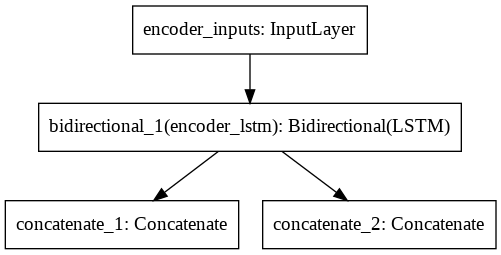

In [15]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(encoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=encoder_model, show_shapes=False,
    to_file='encoder.png'
)
Image(retina=True, filename='encoder.png')

### 3.2. Decoder network

- Inputs:  

    -- one-hot encode of the target language
    
    -- The initial hidden state $h_t$ 
    
    -- The initial conveyor belt $c_t$ 

- Return: 

    -- output (all the hidden states) $h_1, \cdots , h_t$

    -- the final hidden state  $h_t$ (discarded in the training and used in the prediction)
    
    -- the final conveyor belt $c_t$ (discarded in the training and used in the prediction)

In [16]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# inputs of the decoder network
decoder_input_h = Input(shape=(latent_dim * 2,), name='decoder_input_h')
decoder_input_c = Input(shape=(latent_dim * 2,), name='decoder_input_c')
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')

# set the LSTM layer
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, 
                    return_state=True, dropout=0.5, name='decoder_lstm')
decoder_lstm_outputs, state_h, state_c = decoder_lstm(decoder_input_x, 
                                                      initial_state=[decoder_input_h, decoder_input_c])

# set the dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_lstm_outputs)

# build the decoder network model
decoder_model = Model(inputs=[decoder_input_x, decoder_input_h, decoder_input_c],
                      outputs=[decoder_outputs, state_h, state_c],
                      name='decoder')
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_x (InputLayer)    (None, None, 30)     0                                            
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    (None, 512)          0                                            
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 512),  1112064     decoder_input_x[0][0]            
                                                                 decoder_input_h[0][0]      

Print a summary and save the encoder network structure to "./decoder.pdf"

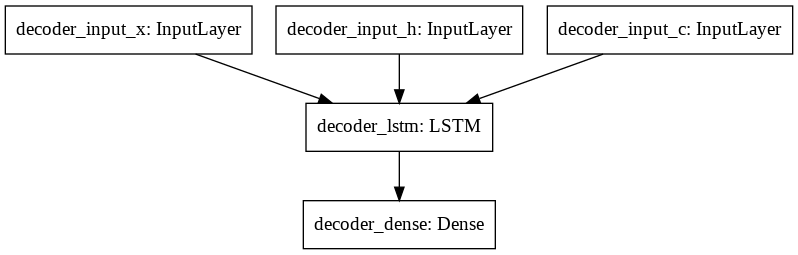

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(decoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=decoder_model, show_shapes=False,
    to_file='decoder.png'
)

Image(retina=True, filename='decoder.png')

### 3.3. Connect the encoder and decoder

In [18]:
# input layers
encoder_input_x = Input(shape=(None, num_encoder_tokens), name='encoder_input_x')
decoder_input_x = Input(shape=(None, num_decoder_tokens), name='decoder_input_x')

# connect encoder to decoder
encoder_final_states = encoder_model([encoder_input_x])
decoder_lstm_output, _, _ = decoder_lstm(decoder_input_x, initial_state=encoder_final_states)
decoder_pred = decoder_dense(decoder_lstm_output)

model = Model(inputs=[encoder_input_x, decoder_input_x], 
              outputs=decoder_pred, 
              name='model_training')

model.summary()

Model: "model_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    (None, None, 28)     0                                            
__________________________________________________________________________________________________
decoder_input_x (InputLayer)    (None, None, 30)     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 512), (None, 583680      encoder_input_x[0][0]            
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 512),  1112064     decoder_input_x[0][0]            
                                                                 encoder[1][0]       

In [19]:
print(state_h)
print(decoder_input_h)

Tensor("decoder_lstm/while/Exit_2:0", shape=(?, 512), dtype=float32)
Tensor("decoder_input_h:0", shape=(?, 512), dtype=float32)


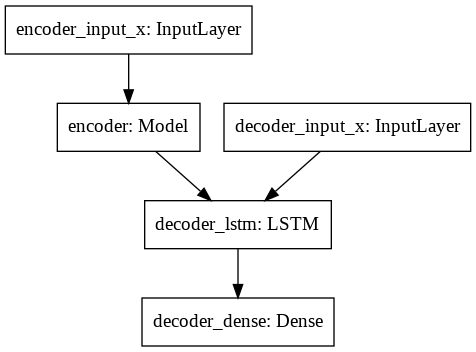

In [20]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=model, show_shapes=False,
    to_file='model_training.png'
)
Image(retina=True, filename='model_training.png')

### 3.5. Fit the model on the bilingual dataset

- encoder_input_data: one-hot encode of the input language

- decoder_input_data: one-hot encode of the input language

- decoder_target_data: labels (left shift of decoder_input_data)

- tune the hyper-parameters

- stop when the validation loss stop decreasing.

In [21]:
print('shape of encoder_input_data' + str(encoder_input_data.shape))
print('shape of decoder_input_data' + str(decoder_input_data.shape))
print('shape of decoder_target_data' + str(decoder_target_data.shape))

shape of encoder_input_data(100000, 255, 28)
shape of decoder_input_data(100000, 297, 30)
shape of decoder_target_data(100000, 297, 30)


In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.fit([encoder_input_data, decoder_input_data],  # training data
          decoder_target_data,                       # labels (left shift of the target sequences)
          batch_size=64, epochs=3, validation_split=0.2)

model.save('seq2seq.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 80000 samples, validate on 20000 samples
Epoch 1/3





80000/80000 [==============================] - 1187s 15ms/step - loss: 0.2509 - val_loss: 0.1705
Epoch 2/3
80000/80000 [==============================] - 1154s 14ms/step - loss: 0.1672 - val_loss: 0.1343
Epoch 3/3
80000/80000 [==============================] - 1150s 14ms/step - loss: 0.1401 - val_loss: 0.1150


## 4. Make predictions


### 4.1. Translate English to Italian

1. Encoder read a sentence (source language) and output its final states, $h_t$ and $c_t$.
2. Take the [star] sign "\t" and the final state $h_t$ and $c_t$ as input and run the decoder.
3. Get the new states and predicted probability distribution.
4. sample a char from the predicted probability distribution
5. take the sampled char and the new states as input and repeat the process (stop if reach the [stop] sign "\n").

In [0]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
  states_value = encoder_model.predict(input_seq)
  target_seq = numpy.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, target_token_index['\t']] = 1.
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    # this line of code is greedy selection
    # try to use multinomial sampling instead (with temperature)
    sampled_token_index = numpy.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
    if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
    target_seq = numpy.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    states_value = [h, c]
  return decoded_sentence


In [26]:
for seq_index in range(2100, 2120):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('English:       ', input_texts[seq_index])
    print('Italian (true): ', target_texts[seq_index][1:-1])
    print('Italian (pred): ', decoded_sentence[0:-1])


-
English:        tom is nervous
Italian (true):  tom e nervoso
Italian (pred):  tom e un po di te
-
English:        why did you tell that joke
Italian (true):  perche hai raccontato quella barzelletta
Italian (pred):  perche siete cosi stanco
-
English:        i feel like going on a trip
Italian (true):  mi va di fare un viaggio
Italian (pred):  mi sono stato un po di capilla
-
English:        your french has gotten better
Italian (true):  il vostro francese e migliorato
Italian (pred):  la sua camina e un buon parte
-
English:        its too far to walk
Italian (true):  e troppo lontana per andare a piedi
Italian (pred):  e troppo compesso
-
English:        he made it plain that he wanted to marry her
Italian (true):  lui mise in chiaro che voleva sposarla
Italian (pred):  lui ha detto che sia stato di nuovare il suo nome
-
English:        tom is going to be back in an hour
Italian (true):  tom sara di ritorno fra unora
Italian (pred):  tom si sta comprando di mary
-
English:        

### 4.2. Translate an English sentence to the target language

1. Tokenization
2. One-hot encode
3. Translate

In [27]:
input_sentence = 'why is that'

input_sequence = text2sequences(max_encoder_seq_length, input_sentence)[0]

input_x = onehot_encode(input_sequence, max_encoder_seq_length, num_encoder_tokens)

translated_sentence = decode_sequence(input_x)

print('source sentence is: ' + input_sentence)
print('translated sentence is (Italian): ' + translated_sentence)

source sentence is: why is that
translated sentence is (Italian): tom e ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancora ancor


## 5. Evaluate the translation using BLEU score

Reference: 
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://en.wikipedia.org/wiki/BLEU


**Hint:** 

- Randomly partition the dataset to training, validation, and test. 

- Evaluate the BLEU score using the test set. Report the average.

- A reasonable BLEU score should be 0.1 ~ 0.3.

In [0]:
cleaned_data = clean_data(pairs)[n_train: n_train + 2000]
input_test_texts, target_test_texts = cleaned_data[:, 0], cleaned_data[:, 1]

In [33]:
print(len(input_test_texts), len(target_test_texts))
print("[{0}] => [{1}]".format(input_test_texts[0], target_test_texts[0]))

2000 2000
[theyre small] => [sono basse]


In [34]:
from nltk.translate.bleu_score import sentence_bleu
score = 0
for i, input_sentence in enumerate(input_test_texts):
  input_sequence,_ = text2sequences(len(input_sentence), input_sentence)
  input_x = onehot_encode(input_sequence, len(input_sentence), num_encoder_tokens)
  translated_sentence = decode_sequence(input_x)
  reference = translated_sentence.split()
  candidate = target_test_texts[i].split()
  s = sentence_bleu(reference, candidate)
  score += s
  # print("Ground truth {0}\nPredicted {1}\n BLEU score {2:.3f}\n\n".format(candidate, reference, s))  
print("Average BLEU score {0:.3f}".format(score / len(input_test_texts)))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLEU score 0.102
